In [6]:
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install matplotlib.pyplot
%pip install statsmodels
%pip install matplotlib
%pip install catboost
%pip install openpyxl
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

0:	learn: 12147.3447014	test: 6456.4581300	best: 6456.4581300 (0)	total: 15.5ms	remaining: 7.73s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2171.923534
bestIteration = 20

Shrink model to first 21 iterations.
MAE: 2033.6351
RMSE: 2171.9235


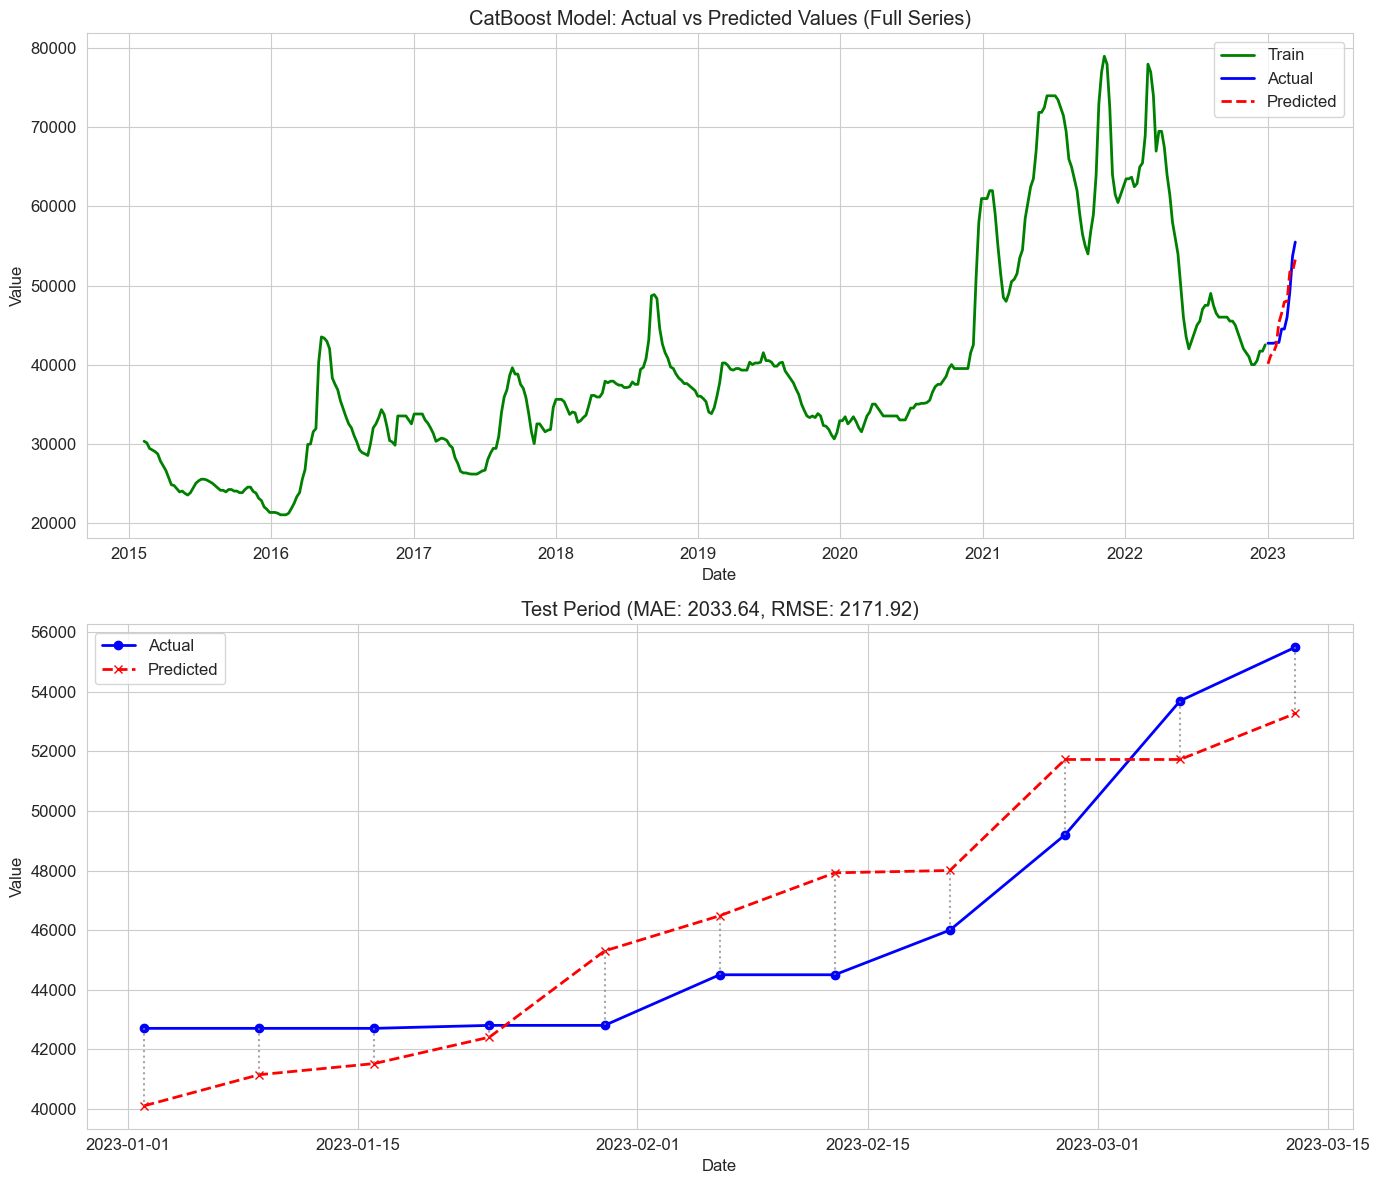

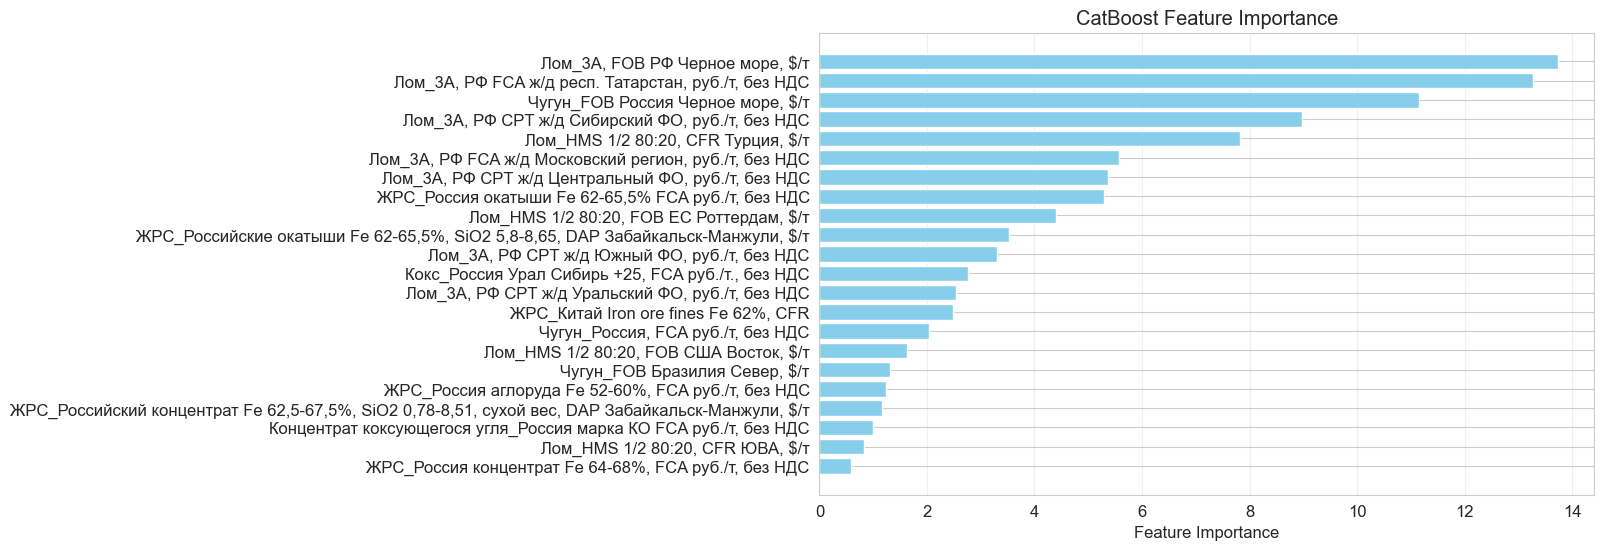

In [16]:
import pandas as pd
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Настройка стиля графиков
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Загрузка и подготовка данных
def load_and_prepare_data(filepath):
    data = pd.read_csv(filepath)
    data['dt'] = pd.to_datetime(data['dt'])
    data.set_index('dt', inplace=True)
    
    # Добавление лагов (если нужно)
    lag_days = 0
    for lag in range(1, lag_days + 1):
        data[f'lag_{lag}'] = data['pfr'].shift(lag)
    
    features = [col for col in data.columns if col != 'pfr']
    return data, features

# Разделение данных
def split_data(data, test_size=11):
    train = data.head(-test_size)
    test = data.tail(test_size)
    return train, test

# Обучение модели
def train_model(X_train, y_train, X_test, y_test):
    model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        eval_metric='RMSE',
        verbose=100,
        random_state=42
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        early_stopping_rounds=50
    )
    
    return model

# Оценка модели
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    return y_pred

# Визуализация результатов
def plot_results(y_train, y_test, y_pred, model_name="CatBoost"):
    # Создаем фигуру с двумя subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # Полный график (train + test)
    ax1.plot(y_train.index, y_train, label='Train', color='green', linewidth=2)
    ax1.plot(y_test.index, y_test, label='Actual', color='blue', linewidth=2)
    ax1.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)
    ax1.set_title(f'{model_name} Model: Actual vs Predicted Values (Full Series)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True)
    
    # Тестовый период с аннотацией ошибок
    ax2.plot(y_test.index, y_test, label='Actual', color='blue', marker='o', linewidth=2)
    ax2.plot(y_test.index, y_pred, label='Predicted', color='red', marker='x', linestyle='--', linewidth=2)
    
    # Добавляем линии ошибок
    for idx, (actual, pred) in enumerate(zip(y_test, y_pred)):
        ax2.plot([y_test.index[idx], y_test.index[idx]], [actual, pred], 
                color='gray', linestyle=':', alpha=0.7)
    
    # Вычисляем и отображаем метрики в заголовке
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ax2.set_title(f'Test Period (MAE: {mae:.2f}, RMSE: {rmse:.2f})')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Визуализация важности признаков
def plot_feature_importance(model, feature_names):
    importance = model.get_feature_importance()
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('CatBoost Feature Importance')
    plt.grid(axis='x', alpha=0.3)
    plt.show()

# Основной процесс
def main():
    # Загрузка данных
    data, features = load_and_prepare_data('data_combined_proto.csv')
    
    # Разделение данных
    train, test = split_data(data)
    X_train, y_train = train[features], train['pfr']
    X_test, y_test = test[features], test['pfr']
    
    # Обучение модели
    model = train_model(X_train, y_train, X_test, y_test)
    
    # Оценка модели
    y_pred = evaluate_model(model, X_test, y_test)
    
    # Визуализация
    plot_results(y_train, y_test, y_pred)
    plot_feature_importance(model, features)

if __name__ == "__main__":
    main()